## Imports

In [1]:
import numpy as np
from numpy import array
from numpy import argmax
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns

## Loading our Data

In [2]:
## first we extract our data from the csv files and load them into pandas dataframes
shared_articles = pd.read_csv("archive/shared_articles.csv")
user_interactions = pd.read_csv("archive/users_interactions.csv")

## Exploratory Data Analysis

In [3]:
## dropping non-unique articles for now to avoid aggregation problems
shared_articles = shared_articles.drop_duplicates(subset=['contentId'])
print(shared_articles.shape)
print(shared_articles.head())
print("number of unique authors" , len(shared_articles['authorPersonId'].unique()))
print(shared_articles['eventType'].describe())
shared_articles.describe()

(3057, 13)
    timestamp        eventType            contentId       authorPersonId  \
0  1459192779  CONTENT REMOVED -6451309518266745024  4340306774493623681   
1  1459193988   CONTENT SHARED -4110354420726924665  4340306774493623681   
2  1459194146   CONTENT SHARED -7292285110016212249  4340306774493623681   
3  1459194474   CONTENT SHARED -6151852268067518688  3891637997717104548   
4  1459194497   CONTENT SHARED  2448026894306402386  4340306774493623681   

       authorSessionId authorUserAgent authorRegion authorCountry contentType  \
0  8940341205206233829             NaN          NaN           NaN        HTML   
1  8940341205206233829             NaN          NaN           NaN        HTML   
2  8940341205206233829             NaN          NaN           NaN        HTML   
3 -1457532940883382585             NaN          NaN           NaN        HTML   
4  8940341205206233829             NaN          NaN           NaN        HTML   

                                             

,timestamp,contentId,authorPersonId,authorSessionId
count,3.057000e+03,3.057000e+03,3.057000e+03,3.057000e+03
mean,1.468847e+09,1.783011e+16,4.279872e+17,1.764257e+17
std,7.570536e+06,5.376278e+18,4.394977e+18,5.391539e+18
min,1.459193e+09,-9.222795e+18,-9.120686e+18,-9.212055e+18
25%,1.462393e+09,-4.673604e+18,-1.578288e+18,-4.653302e+18
50%,1.467145e+09,3.455744e+16,-7.092877e+17,4.029735e+17
75%,1.473891e+09,4.716136e+18,3.609194e+18,4.821078e+18
max,1.488308e+09,9.222265e+18,9.210531e+18,9.221043e+18


In [4]:
user_interactions.describe()

,timestamp,contentId,personId,sessionId
count,7.231200e+04,7.231200e+04,7.231200e+04,7.231200e+04
mean,1.470103e+09,-3.033423e+16,1.252026e+16,3.421273e+16
std,7.258130e+06,5.344755e+18,5.022333e+18,5.344355e+18
min,1.457964e+09,-9.222795e+18,-9.223122e+18,-9.222505e+18
25%,1.464876e+09,-4.726309e+18,-3.596627e+18,-4.613476e+18
50%,1.468343e+09,1.893099e+16,-1.088422e+17,5.029492e+16
75%,1.474461e+09,4.441012e+18,3.766319e+18,4.667962e+18
max,1.488310e+09,9.222265e+18,9.210531e+18,9.223314e+18


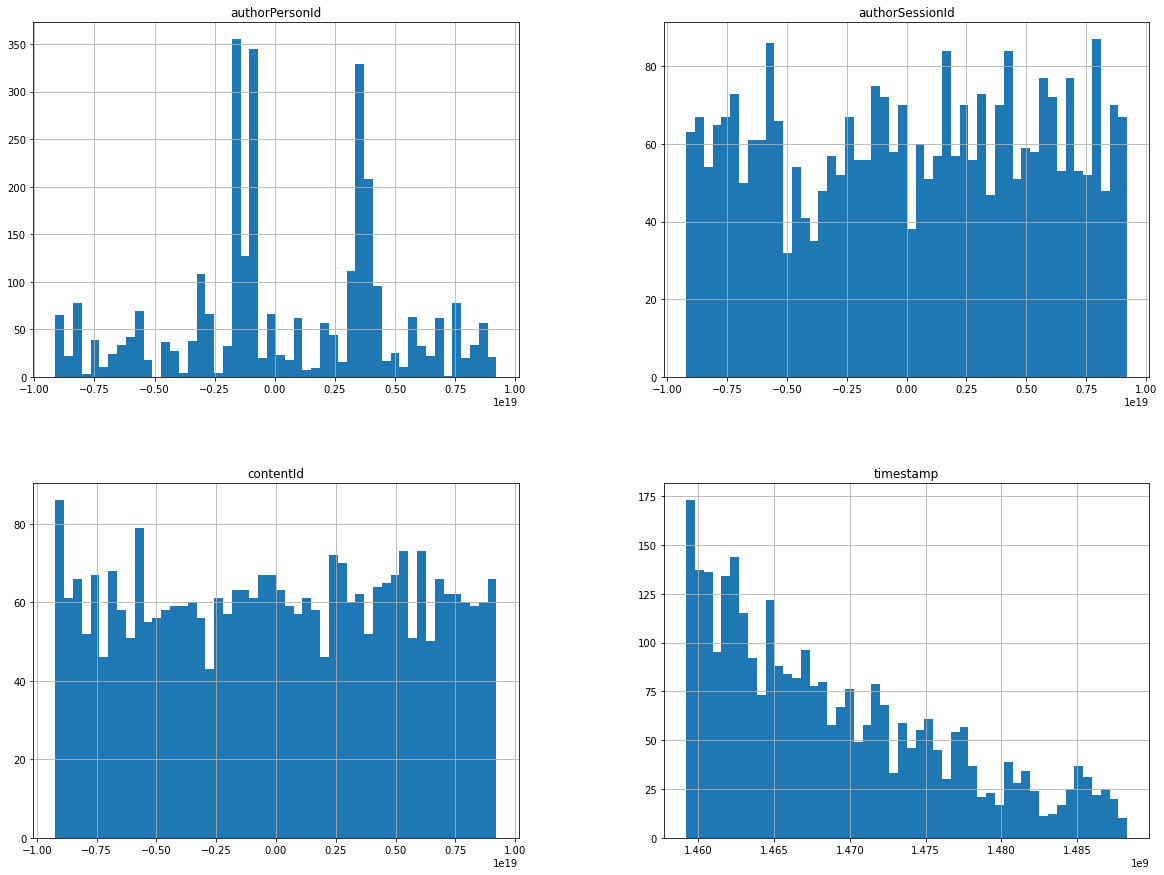

In [5]:
shared_articles.hist(bins=50, figsize=(20,15))
plt.show()

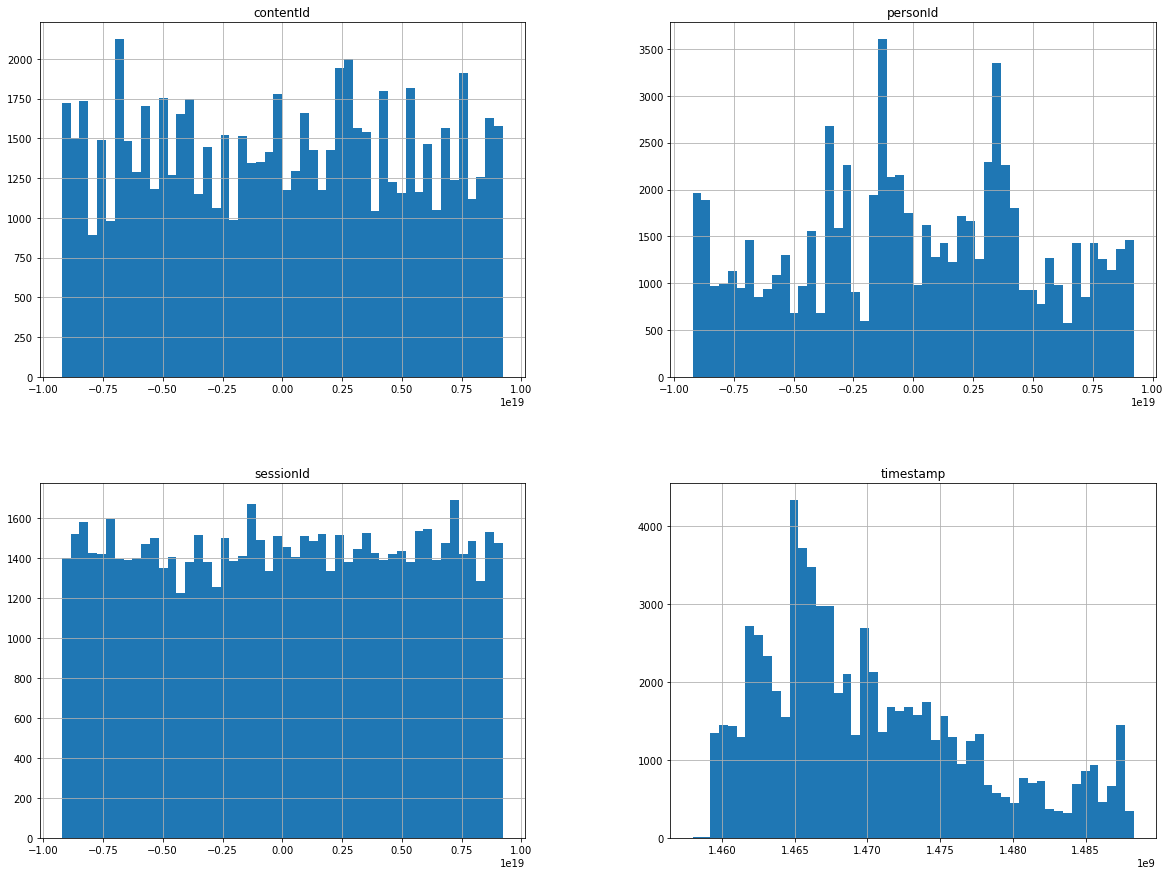

In [6]:
user_interactions.hist(bins=50, figsize=(20,15))
plt.show()

## Calculating Virality Scores + More Data Exploration

In [7]:
## lets join the df
joined = pd.merge(shared_articles, user_interactions, on='contentId', how='left')
print(joined.shape)

(72382, 20)


In [8]:
## our aggregate dataframe to calculate virality
aggs = joined.groupby(['contentId', 'eventType_y']).eventType_y.count().unstack(1)
print(aggs.head())
aggs.shape

eventType_y           BOOKMARK  COMMENT CREATED  FOLLOW  LIKE  VIEW
contentId                                                          
-9222795471790223670       1.0              2.0     3.0   4.0  16.0
-9216926795620865886       1.0              1.0     1.0   3.0  15.0
-9194572880052200111       2.0              1.0     1.0   4.0  21.0
-9192549002213406534       NaN              1.0     NaN   5.0  50.0
-9190737901804729417       NaN              NaN     NaN   1.0   8.0


(2987, 5)

In [9]:
## impute 0 for the events dont dont appear for an article
aggs = aggs.fillna(0) 
aggs['VIRALITY'] = aggs.VIEW + 4*aggs.LIKE + 10*aggs['COMMENT CREATED']+ 25*aggs.FOLLOW + 100*aggs.BOOKMARK
aggs.head()

eventType_y,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW,VIRALITY
contentId,,,,,,
-9222795471790223670,1.0,2.0,3.0,4.0,16.0,227.0
-9216926795620865886,1.0,1.0,1.0,3.0,15.0,162.0
-9194572880052200111,2.0,1.0,1.0,4.0,21.0,272.0
-9192549002213406534,0.0,1.0,0.0,5.0,50.0,80.0
-9190737901804729417,0.0,0.0,0.0,1.0,8.0,12.0


In [10]:
## now lets join the virality score back to the shared_articles set
shared_articles = pd.merge(shared_articles, aggs, on='contentId', how='left')

In [11]:
shared_articles.dropna(subset=["VIRALITY"], inplace=True)
shared_articles.shape # to make sure size is consistent

(2987, 19)

In [12]:
shared_articles['VIRALITY'].describe()
## there seems to be a good range of virality scores to train and test on

count    2987.000000
mean      127.770673
std       259.044552
min         1.000000
25%         8.000000
50%        43.000000
75%       150.000000
max      7907.000000
Name: VIRALITY, dtype: float64

VIRALITY           1.000000
BOOKMARK           0.969403
LIKE               0.632325
VIEW               0.621390
FOLLOW             0.451955
COMMENT CREATED    0.398356
authorPersonId     0.022594
timestamp          0.009981
contentId          0.006876
authorSessionId   -0.000889
Name: VIRALITY, dtype: float64


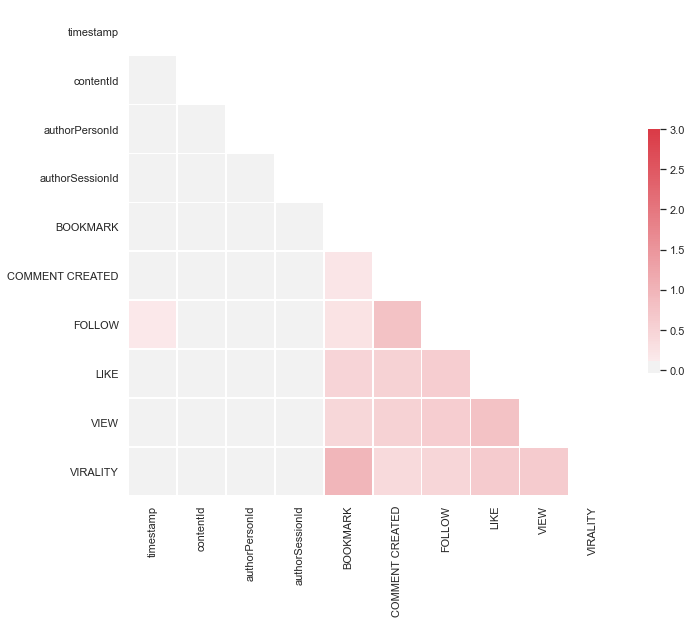

In [13]:
# lets see the correlation matrix to scope out features
corr_matrix = shared_articles.corr()
print(corr_matrix['VIRALITY'].sort_values(ascending=False))

# heatmap
sns.set(style="white")
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

# setup
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=3, center=0,
           square=True, linewidths=.5, cbar_kws={"shrink": .5})

## as expected, we see that the user interactions have a high correlation with each other,
## but the other features available to us do not have big correlations with each other

Now we must create features that will allow us to predict the virality score of a new article

## Current features available
1. timestamp
2. authorPersonId
3. authorSessionId
3. authorUserAgent
4. authorRegion
5. authorCountry
6. contentType -- they are mostly html 
7. url -- most are unique
8. title
9. text 
10. lang


## feature engineering -- These are the features we will consider using in our model. The ones I end up using are marked with *
1. datetime [datetime]* --> one-hot encoding of the day the article was posted
2. authorId* --> one-hot encoding by author name
3. authorSessionId
4. contentType* --> one-hot encoding (HTML, RICH, VIDEO)
5. url_domain[removed] -- one-hot encoding of what website the article was posted to
6. author_region* -- what region the author belongs to
    --> one-hot encoding ('?' 'MG' 'ON' 'SP' 'GA' 'NY' 'IL' 'NSW' 'RI' 'NJ' 'RJ' 'TX' 'AB' 'FL' 'WA' 'CA' 'SC' 'MS')
7. article_language* --> one-hot encoding (en,pt,es,la,ja) of what language the article is written in
8. title_importance -- top keywords in the title
9. text_importance -- top keywords in the text
10. text_length* -- length of article
11. title* -> one-hot encoding of top keywords occurring in articles with the highest virality score

##  Data Cleaning + Feature Engineering

In [14]:
## let us cleanup some things first

fs = shared_articles[['timestamp', 'authorPersonId', 'authorRegion', 'contentType', 'url', 'lang', 'title', 'text', 'VIRALITY']]

# datetime -> day_of_week
fs['datetime'] = pd.to_datetime(fs['timestamp'], unit='s')
fs['day_of_week'] = fs['datetime'].dt.dayofweek
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
fs['day_of_week'] = fs['day_of_week'].apply(lambda x: days[x])

def cleanRegion(region):
    if not isinstance(region, str) or region == '?' or not region.isalpha():
        return '?' 
    else:
        return region

def getDomain(url):
    # the third occurrence of '/' is where the domain of the url ends
    # this is also the first occurence of '/' after the first 9 charcters
    temp = url[9:]
    ind = temp.index('/')
    return url[:9+ind+1]
    
fs['url'] = fs.apply(lambda row: getDomain(row['url']), axis=1)
fs['authorRegion'] = fs.apply(lambda row: cleanRegion(row['authorRegion']), axis=1)
fs['textLength'] = fs.apply(lambda row: len(row['text']), axis=1)

## onehot encoding for categorical data
def getOneHotEncoding(values):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return pd.DataFrame(data=onehot_encoded,
                        columns=values.unique()) 

# content -> oneHot (HTML, RICH, VIDEO)
content_oneHot = getOneHotEncoding(fs['contentType'])
# lang -> oneHot (en,pt,es,la,ja)
lang_oneHot = getOneHotEncoding(fs['lang'])
# region -> oneHot ('?' 'MG' 'ON' 'SP' 'GA' 'NY' 'IL' 'NSW' 'RI' 'NJ' 'RJ' 'TX' 'AB' 'FL' 'WA' 'CA' 'SC' 'MS')
region_oneHot = getOneHotEncoding(fs['authorRegion'])

# url -> oneHot (all urls)
# url_oneHot = getOneHotEncoding(fs['url'])

# day_of_week -> oneHot (days of week)
dow_oneHot = getOneHotEncoding(fs['day_of_week'])

# author -> oneHot (all authors)
author_oneHot = getOneHotEncoding(fs['authorPersonId'])

fs = pd.concat([fs, dow_oneHot, content_oneHot, lang_oneHot, region_oneHot, author_oneHot], axis=1, sort=False)
fs = fs.drop(columns=['day_of_week', 'contentType', 'lang', 'authorRegion', 'url', 'authorPersonId', 'datetime'])
fs.dropna(inplace=True)

fs.head()

<ipython-input-14-c61352d59a8a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fs['datetime'] = pd.to_datetime(fs['timestamp'], unit='s')
<ipython-input-14-c61352d59a8a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fs['day_of_week'] = fs['datetime'].dt.dayofweek
<ipython-input-14-c61352d59a8a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

,timestamp,title,text,VIRALITY,textLength,Mon,Tues,Weds,Thurs,Fri,...,-8420584158427265596,-3458422503840091409,8195788452563155020,-1863544689523892600,3118792477913513242,1811781596621121379,-8781306637602263252,8516196196975927,599868086167624974,-5706287032724665714
0,1.459193e+09,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,3.0,6543.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.459194e+09,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,1.0,6543.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.459194e+09,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,1.0,1993.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.459194e+09,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,22.0,1520.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.459195e+09,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,2.0,1824.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
## some helper methods for cleaning text 
## and generating tf-idf scores for keyword extraction

## now lets try to create a list of keywords for each article
def clean_text(text):
    # lowercase
    text=text.lower()
    #remove tags
    text=re.sub("","",text)
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    return text

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_top_from_vector(feature_names, sorted_items,n):
    """get the feature names and tf-idf score of top n items"""
    #use only topn items from vector
    sorted_items = sorted_items[:n]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    return results



## INITIAL ATTEMPT TO EXTRACT KEYWORDS FROM EACH ARTICLE 
## -- REALIZED THIS WOULD BE VERY COMPLICATED TO USE IN A MODEL

# def extractKeywords(textbody, n):
#     # textbody is the column for which to extract keywords
#     # n is the number of keywords we want

#     def getKeywords(text,n):
#         tf_idf_vector=tfidf_transformer.transform(cv.transform([text]))
#         sorted_items=sort_coo(tf_idf_vector.tocoo())
#         keywords=extract_top_from_vector(feature_names,sorted_items,n)
#         return keywords
    
#     fs[textbody] = fs.apply(lambda row: clean_text(row[textbody]), axis=1)
#     docs = fs[textbody].tolist()
#     word_count_vector = cv.fit_transform(docs)
#     feature_names=cv.get_feature_names()


#     # now calculate idf
#     tfidf_transformer.fit(word_count_vector)
#     return fs.apply(lambda row: getKeywords(row[textbody], n), axis=1)

# cv = CountVectorizer(max_df = 0.70, stop_words='english')
# tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)

# fs['titleKeywords'] = extractKeywords('title', 3) 
# fs['textKeywords'] = extractKeywords('text', 10) 


In [16]:
## APPROACH 2: Extracting words with top tf-df scores across articles with
## the highest virality scores and using a one-hot encoding of those words

def getKeywords(text,n):
    tf_idf_vector=tfidf_transformer.transform(cv.transform([text]))
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    keywords=extract_top_from_vector(feature_names,sorted_items,n)
    return keywords

cv = CountVectorizer(max_df = 0.70, stop_words='english')
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
most_viral_df = fs[fs['VIRALITY'] > 500]

docs = most_viral_df['title'].tolist()
word_count_vector = cv.fit_transform(docs)
feature_names=cv.get_feature_names()
tfidf_transformer.fit(word_count_vector)
all_titles = ' '.join(most_viral_df['title'])
top_title_words = list(getKeywords(all_titles, 10))
top_title_words



['para', 'que', '2016', 'apps', 'em', 'com', 'um', 'app', 'use', 'web']

In [17]:
## Creating a one-hot encoding of these words and appending to our dataframe

title_words_df = pd.DataFrame(columns=top_title_words)

def keyword_oneHot(title):
    mylist = []
    myset = set(title.split(" "))
    
    for word in top_title_words:
        if word in myset:
            mylist.append(1)
        else:
            mylist.append(0)

    title_words_df.loc[len(title_words_df)] = mylist
    return title

fs.apply(lambda row: keyword_oneHot(row['title']), axis=1)

fs = fs.reset_index(drop=True)
fs = fs.join(title_words_df)


## Learning Method - Random Forest Classifier

In [21]:
## now lets do some machine learning
fs = fs.drop(['title', 'text'], axis=1)

X = fs.drop(['VIRALITY'], axis=1)
y = fs['VIRALITY'].to_frame()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

KeyError: "['title' 'text'] not found in axis"

<ipython-input-27-7ba0d5ba578d>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X, y)


Mean squared error: 7809.38
Coefficient of determination: 0.82
Mean absolute error: 48.37
Feature: 0, Score: 0.19430
Feature: 1, Score: 0.33629
Feature: 2, Score: 0.00947
Feature: 3, Score: 0.02801
Feature: 4, Score: 0.00115
Feature: 5, Score: 0.00741
Feature: 6, Score: 0.01087
Feature: 7, Score: 0.01271
Feature: 8, Score: 0.01565
Feature: 9, Score: 0.00029
Feature: 10, Score: 0.00001
Feature: 11, Score: 0.00019
Feature: 12, Score: 0.00686
Feature: 13, Score: 0.00002
Feature: 14, Score: 0.00004
Feature: 15, Score: 0.00001
Feature: 16, Score: 0.00678
Feature: 17, Score: 0.00575
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00005
Feature: 21, Score: 0.00023
Feature: 22, Score: 0.00013
Feature: 23, Score: 0.00350
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00023
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00161
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00067
Feature: 31, Score: 0.00014
Feature: 32, Score: 0.00

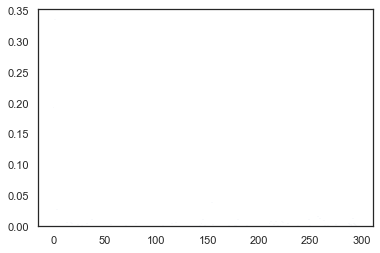

In [27]:

## using a random forest regression -- previously also tried linear regression

regressor = RandomForestRegressor(n_estimators=10, random_state=0)
regressor.fit(X, y)

y_pred = regressor.predict(X_test)

print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

print('Mean absolute error: %.2f'
      % mean_absolute_error(y_test, y_pred))

importance = regressor.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [25]:
## Mean Square Error and r2 indicates that we have reached reasonable accuracy for our model
## turns out the feature that helped the most was the length of the article!